In [1]:
import torch
from torchviz import make_dot
import numpy as np

In [2]:
torch.__version__
device = 'cuda' if torch.cuda.is_available()  else 'cpu'
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

NVIDIA GeForce MX130


## Tensor Operations

#### Create Tensor

In [3]:
scalar = torch.tensor(3.14, device=device)
vector = torch.tensor([1, 2, 3], device=device)
matrix = torch.tensor([[1, 2, 3], [4, 5, 6]], device=device)
tensor = torch.tensor([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [0, 1, 2]]], device=device)
print(scalar)
print(vector)
print(matrix)
print(tensor)

tensor(3.1400, device='cuda:0')
tensor([1, 2, 3], device='cuda:0')
tensor([[1, 2, 3],
        [4, 5, 6]], device='cuda:0')
tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[7, 8, 9],
         [0, 1, 2]]], device='cuda:0')


In [4]:
tensor.size(), tensor.shape

(torch.Size([2, 2, 3]), torch.Size([2, 2, 3]))

#### Reshape Tensor

In [5]:
# Use view() method to reshape the tensor
# Beware: the view() method only returns a tensor with the dsired shape
# that shares the same underlying data with original tensor - it DOES NOT create a new tensor!
same_matrix = matrix.view(1, -1)
print(same_matrix)
print(matrix)

tensor([[1, 2, 3, 4, 5, 6]], device='cuda:0')
tensor([[1, 2, 3],
        [4, 5, 6]], device='cuda:0')


In [6]:
same_matrix[0, 0] = 100
print(same_matrix)
print(matrix)

tensor([[100,   2,   3,   4,   5,   6]], device='cuda:0')
tensor([[100,   2,   3],
        [  4,   5,   6]], device='cuda:0')


#### Copy Tensor

In [7]:
# use .clone().detach() to copy a tensor instead of view()
other_tensor = same_matrix.clone().detach()
other_tensor[0,0] = 1234
print(same_matrix)
print(other_tensor)
# search detach() and clone() in pytorch doc for more details

tensor([[100,   2,   3,   4,   5,   6]], device='cuda:0')
tensor([[1234,    2,    3,    4,    5,    6]], device='cuda:0')


In [8]:
# if tensor in GPU, we must conver to cpu first, then convert to numpy
print(other_tensor.device)
other_tensor.cpu().numpy()

cuda:0


array([[1234,    2,    3,    4,    5,    6]])

## Normal Tensor versus Trainable Tensor

- Normal Tensor: Doesn't require gradient computation.
- Trainable Tensor (Parameter/weight): Requires gradient computation.

In [9]:
# Standard method to create Trainable Tensor
# We must specify the requires_grad=True to track computation
# and specify the device to be the GPU
# this method also accelerates the computation (see 7 PyTorch Tips Github)
torch.manual_seed(7)
b = torch.randn(1, requires_grad=True, device=device)
w = torch.randn(1, requires_grad=True, device=device)
print(b, w)

tensor([-0.3048], device='cuda:0', requires_grad=True) tensor([-1.2870], device='cuda:0', requires_grad=True)


## Autograd

Autograd is PyTorch's *automatic differentiation package* that automatically calculates derivatives, chain rule or anything like it.

#### backward

backward() method compute all gradients for all (requires_grad=True) tensors involved in the computation of a given variable.

In [10]:
x_train = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9], device=device, dtype=torch.float32)
y_train = torch.tensor([11, 22, 33, 44, 53, 66, 77, 87, 95], device=device, dtype=torch.float32)

In [11]:
# Autograd in action
# Step 1 - Computes our model's predicted output - forward pass
yhat = b + w * x_train

# Step 2 - Computes the loss
error = (yhat - y_train)
loss = (error ** 2).mean()

# Step 3 - Computes the gradients for every parameter with requires_grad=True
loss.backward()

In [12]:
print(b.requires_grad, w.requires_grad, loss.requires_grad, error.requires_grad)
print(x_train.requires_grad, y_train.requires_grad)

True True True True
False False


#### grad

Use grad attribute to check actual values of the gradients

In [13]:
b.grad, w.grad, loss.grad, error.grad
# grad value of loss and error is None because they are not leaf node

/tmp/ipykernel_12218/1389219517.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  b.grad, w.grad, loss.grad, error.grad


(tensor([-121.9243], device='cuda:0'),
 tensor([-769.2258], device='cuda:0'),
 None,
 None)

* **NOTE**: PyTorch default is accumulating gradients. We need to clear them out before each instance.

zero_

In [14]:
# Every time we use the gradients to update the parameters, we need to zero the gradients afterwards.
b.grad.zero_(), w.grad.zero_()

(tensor([0.], device='cuda:0'), tensor([0.], device='cuda:0'))

#### Updating Parameters

In [15]:
# Sets learning rate - this is 'eta'
lr = 0.0000001

# Step 0: Initializes parameters 'b' and 'w' randomly
torch.manual_seed(7)
b = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)
w = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)


# Defines nubmer of epochs
n_epochs = 100


for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train

    # Step 2 - Computes the loss
    error = y_train - yhat
    # MSE
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both 'b' and 'w'
    loss.backward()

    # Step 4 - Updates parameters using gradients and the learning rate
    with torch.no_grad():
        b -= lr * b.grad
        w -= lr * w.grad

    # Zero gradients
    b.grad.zero_()
    w.grad.zero_()
print(b,w)

tensor([0.9556], device='cuda:0', requires_grad=True) tensor([0.4135], device='cuda:0', requires_grad=True)


#### Dynamic Computation Graph

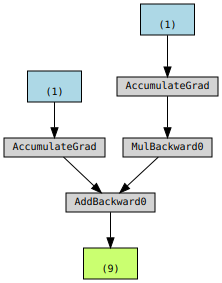

In [16]:
make_dot(yhat)

* **NOTE**: No gradients, No graph!

## Optimizer

- We use optimizer to update all parameters of model.
- Remember, the choice of mini-batch size and optimizer influenced the path of gradient descent.

#### step / zero_grad

In [17]:
# Defines an SGD optimizer to update the parameters
optimizer = torch.optim.SGD([b, w], lr=lr)

In [18]:
# Sets learning rate - this is 'eta'
lr = 0.001

# Step 0: Initializes parameters 'b' and 'w' randomly
torch.manual_seed(7)
b = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)
w = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)


# Defines nubmer of epochs
n_epochs = 100


for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train

    # Step 2 - Computes the loss
    error = y_train - yhat
    # MSE
    loss = (error ** 2).mean()

    # Step 3 - Computes gradients for both 'b' and 'w'
    loss.backward()

    # Step 4 - Updates parameters using gradients and the learning rate
    # OLD METHOD
    # with torch.no_grad():
    #     b -= lr * b.grad
    #     w -= lr * w.grad
    # NEW METHOD
    optimizer.step()


    # Zero gradients
    # OLD METHOD
    # b.grad.zero_()
    # w.grad.zero_()
    # NEW METHOD
    optimizer.zero_grad()
    
print(b,w)

tensor([0.9546], device='cuda:0', requires_grad=True) tensor([0.4070], device='cuda:0', requires_grad=True)


## LOSS

* **NOTE**: You can also specify a reduction method to be apllied, that is how do you want to aggregate the errors for individual points (reduction='mean') or simply sum them up (reduction='sum')

In [19]:
loss_fn = torch.nn.MSELoss(reduction='mean')

In [20]:
# Sets learning rate - this is 'eta'
lr = 1e-5

# Step 0: Initializes parameters 'b' and 'w' randomly
torch.manual_seed(7)
b = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)
w = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)
optimizer = torch.optim.SGD([b, w], lr=lr)


# Defines nubmer of epochs
n_epochs = 10000


for epoch in range(n_epochs):
    # Step 1 - Computes model's predicted output - forward pass
    yhat = b + w * x_train

    # Step 2 - Computes the loss
    # OLD METHOD
    # error = y_train - yhat
    # # MSE
    # loss = (error ** 2).mean()
    # NEW METHOD
    loss = loss_fn(yhat, y_train)

    # Step 3 - Computes gradients for both 'b' and 'w'
    loss.backward()

    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()

    # Zero gradients
    optimizer.zero_grad()
    
print(b,w)

# if we want to convert loss to numpy
print('loss.item(): ', loss.item())
# or
print('loss.tolist(): ', loss.tolist())

tensor([2.4715], device='cuda:0', requires_grad=True) tensor([10.4031], device='cuda:0', requires_grad=True)
loss.item():  1.6535767316818237
loss.tolist():  1.6535767316818237


## Model

- In PyTorch, a model is represented by a regular Python class that inherits from the Module class.

In [21]:
class ManualLinearRegression(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # To make 'b' and 'w' real parameters of the model,
        # we need to wrap them with nn.Parameter
        self.b = torch.nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float32))
        self.w = torch.nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float32))

    def forward(self, x):
        # Compute outputs / predictions values
        return self.b + self.w * x


#### Parameters

- In that example, we use torch.nn.Parameter() to create parameters for model. This tell PyTorch that these tensors are attributes of the class, should be considered parameters of the model.

In [22]:
torch.manual_seed(7)
dummy_model = ManualLinearRegression()
list(dummy_model.parameters())

[Parameter containing:
 tensor([0.5349], requires_grad=True),
 Parameter containing:
 tensor([0.1988], requires_grad=True)]

#### state_dict

In [23]:
dummy_model.state_dict()

OrderedDict([('b', tensor([0.5349])), ('w', tensor([0.1988]))])

- state_dict() method only returns **leanable parameters** of model, as it purpose is to keep track of parameters that are going to be updated by the **optimizer**.

In [24]:
# optimizer has state_dict too, which contain hyper-parameter of optimizer
optimizer.state_dict()

{'state': {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}},
 'param_groups': [{'lr': 1e-05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'params': [0, 1]}]}

#### Device

- Data and Model need to be in the same device if we want to train.

In [25]:
model = ManualLinearRegression().to(device=device)

#### Forward Pass

In [26]:
# Sets learning rate - this is 'eta'
lr = 1e-3

# Step 0: Initializes parameters 'b' and 'w' randomly
torch.manual_seed(7)
# Create model and send it to device
model = ManualLinearRegression().to(device)

# Defines optimizer 
# Retrive parameters directly from the model
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Defines MSE loss
loss_fn = torch.nn.MSELoss(reduction='mean')

# Defines nubmer of epochs
n_epochs = 100


for epoch in range(n_epochs):
    model.train()       # Set model in training mode
    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train)

    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train)

    # Step 3 - Computes gradients for both 'b' and 'w'
    loss.backward()

    # Step 4 - Updates parameters using gradients and the learning rate
    optimizer.step()
    # Zero gradients
    optimizer.zero_grad()
    
print(model.state_dict())

OrderedDict([('b', tensor([2.1100], device='cuda:0')), ('w', tensor([10.4632], device='cuda:0'))])


#### Nested Models

In [27]:
class MyLinearRegression(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.linear = torch.nn.Linear(1,1)

    def forward(self, x):

        return self.linear(x)

In [28]:
torch.manual_seed(7)
model_linear = MyLinearRegression().to(device=device)

In [29]:
list(model_linear.parameters())

[Parameter containing:
 tensor([[0.0698]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.6024], device='cuda:0', requires_grad=True)]

#### Sequential Models

In [30]:
model_sequential = torch.nn.Sequential(torch.nn.Linear(1,1)).to(device=device)
model_sequential.state_dict()

OrderedDict([('0.weight', tensor([[0.3184]], device='cuda:0')),
             ('0.bias', tensor([0.3138], device='cuda:0'))])

In [31]:
model = torch.nn.Sequential()
model.add_module('layer 1', torch.nn.Linear(1,1))
model.add_module('layer 2', torch.nn.Linear(1,5))
model.to(device=device)

Sequential(
  (layer 1): Linear(in_features=1, out_features=1, bias=True)
  (layer 2): Linear(in_features=1, out_features=5, bias=True)
)

In [32]:
from collections import OrderedDict
model_sequential = torch.nn.Sequential(OrderedDict([
                                        ('layer n1', torch.nn.Linear(1,1)),
                                        ('layer n2', torch.nn.Linear(1,5))
                                                    ]
                                        )).to(device=device)
model_sequential

Sequential(
  (layer n1): Linear(in_features=1, out_features=1, bias=True)
  (layer n2): Linear(in_features=1, out_features=5, bias=True)
)

## Putting It All Together

#### Data Generation

In [33]:
%%writefile '../data_preparation/v0.py'

true_b = 1
true_w = 2
N = 100

# Data Generation
x = np.random.rand(N, 1)
epsilon = (0.1 * np.random.rand(N, 1))
y = true_b + true_w * x + epsilon

idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*0.8)]
# Uses remaining indices for validation
val_idx = idx[int(N*0.8):]

# Generate train and validatrion sets
x_train, y_train = x[train_idx], y[train_idx]
x_val = x[val_idx], y[val_idx]

x_train_tensor = torch.as_tensor(x_train).float().to(device=device)
y_train_tensor = torch.as_tensor(y_train).float().to(device=device)

Overwriting ../data_preparation/v0.py


#### Model Configuration

In [34]:
%%writefile '../model_configuration/v0.py'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# set learning rate
learning_rate = 1e-3

torch.manual_seed(42)

# Create model and send it to device
model = torch.nn.Sequential(torch.nn.Linear(1,1)).to(device)

# Define SGD optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

Writing ../model_configuration/v0.py


#### Model Training

In [44]:
%%writefile '../model_training/v0.py'

# Defines n_epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Set model to TRAIN mode
    model.train()

    # Step 1 - Forward pass
    y_pred = model(x_train_tensor)

    # Step 2 - Compute Loss
    loss = loss_fn(y_pred, y_train_tensor)

    # Step 3 - Compute gradients
    loss.backward()

    # Step 4 - Update parameters using gradients and the learning rate
    optimizer.step()
    optimizer.zero_grad()

print(list(model.parameters()))

Overwriting ../model_training/v0.py


In [45]:
%run -i '../data_preparation/v0.py'
%run -i '../model_configuration/v0.py'
%run -i '../model_training/v0.py'

[Parameter containing:
tensor([[1.2059]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([1.4151], device='cuda:0', requires_grad=True)]


## SUMMARY

- Creating tensors in PyTorch, sending them to a device and making parameters out of them.
- Understanding PyTorch's main feature, autograd to perform automatic differentiation uisng it associated properties and methods like: backward, grad, zero_, no_grad.
- Visualizing the Dynamic Computational Graphs (DCG) of PyTorch associated with a sequence of operations.
- Creating an optimizer to perform gradient descent and update the parameters of the model, using its step and zero_grad methods.
- Creating a loss function uisngPyTorch's higher-order function.
- Understanding PyTorch's Module class and creating your own models, implementing __init__ and forward methods and making use of its built-in parameters and state_dict methods.
- Realizing the importance of including model.train() in the training loop.
Implementing nested and sequential models using PyTorch's layers.